In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import transforms, datasets, models, utils
from torchsummary import summary # 可视化训练过程
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from PIL import Image

In [2]:
# 分为为train, val, test定义transform
image_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(size=300, scale=(0.8, 1.1)), #功能：随机长宽比裁剪原始图片, 表示随机crop出来的图片会在的0.08倍至1.1倍之间
        transforms.RandomRotation(degrees=10), #功能：根据degrees随机旋转一定角度, 则表示在（-10，+10）度之间随机旋转
        transforms.ColorJitter(0.4, 0.4, 0.4), #功能：修改亮度、对比度和饱和度
        transforms.RandomHorizontalFlip(), #功能：水平翻转
        transforms.CenterCrop(size=256), #功能：根据给定的size从中心裁剪，size - 若为sequence,则为(h,w)，若为int，则(size,size)
        transforms.ToTensor(), #numpy --> tensor
        # 功能：对数据按通道进行标准化（RGB），即先减均值，再除以标准差
        transforms.Normalize([0.485, 0.456, 0.406],# mean
                             [0.229, 0.224, 0.225])# std 
    ]),
    
    'val' : transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],# mean
                             [0.229, 0.224, 0.225])# std 
    ]),
    
     'test' : transforms.Compose([
       transforms.Resize(300),
       transforms.CenterCrop(256),
       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406],# mean
                            [0.229, 0.224, 0.225])# std 
     ])
}

In [3]:
# 加载数据集

# 数据集所在目录路径
data_dir = '4class/'
# train路径
train_dir = data_dir + 'train/'
# val路径
val_dir = data_dir + 'val/'
# test路径
test_dir = data_dir + 'test/'

# 从文件中读取数据
datasets = {
    'train' : datasets.ImageFolder(train_dir, transform=image_transforms['train']), # 读取train中的数据集，并transform
    'val' : datasets.ImageFolder(val_dir, transform=image_transforms['val']),  # 读取val中的数据集，并transform
    'test' : datasets.ImageFolder(test_dir, transform=image_transforms['test']) #  读取test中的数据集，并transform
}

# 定义BATCH_SIZE
BATCH_SIZE = 128 # 每批读取128张图片

# DataLoader : 创建iterator, 按批读取数据
dataloaders = {
    'train' : DataLoader(datasets['train'], batch_size=BATCH_SIZE, shuffle=True), # 训练集
    'val' : DataLoader(datasets['val'], batch_size=BATCH_SIZE, shuffle=True), # 验证集
    'test' : DataLoader(datasets['test'], batch_size=BATCH_SIZE, shuffle=True) # 测试集
}

# 创建label的键值对
LABEL = dict((v, k) for k, v in datasets['train'].class_to_idx.items())

LABEL

{0: 'Bacteria', 1: 'Covid19', 2: 'Normal', 3: 'Viral'}

In [4]:
# train 简介
dataloaders['train'].dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: 4class/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(300, 300), scale=(0.8, 1.1), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
dataloaders['train'].dataset.classes # train下的类别

['Bacteria', 'Covid19', 'Normal', 'Viral']

In [6]:
dataloaders['train'].dataset.root # train的路径

'4class/train/'

In [7]:
# 肺部正常的图片
files_normal = os.listdir(os.path.join(str(dataloaders['train'].dataset.root), 'Normal'))
files_normal

['Normal (1).jpeg',
 'Normal (1).png',
 'Normal (10).jpeg',
 'Normal (10).png',
 'Normal (100).jpeg',
 'Normal (100).png',
 'Normal (1000).jpeg',
 'Normal (1000).png',
 'Normal (1001).jpeg',
 'Normal (1001).png',
 'Normal (1002).jpeg',
 'Normal (1002).png',
 'Normal (1003).jpeg',
 'Normal (1003).png',
 'Normal (1004).jpeg',
 'Normal (1004).png',
 'Normal (1005).jpeg',
 'Normal (1005).png',
 'Normal (1006).jpeg',
 'Normal (1006).png',
 'Normal (1007).jpeg',
 'Normal (1007).png',
 'Normal (1008).jpeg',
 'Normal (1008).png',
 'Normal (1009).jpeg',
 'Normal (1009).png',
 'Normal (101).jpeg',
 'Normal (101).png',
 'Normal (1010).jpeg',
 'Normal (1010).png',
 'Normal (1011).jpeg',
 'Normal (1011).png',
 'Normal (1012).jpeg',
 'Normal (1012).png',
 'Normal (1013).jpeg',
 'Normal (1013).png',
 'Normal (1014).jpeg',
 'Normal (1014).png',
 'Normal (1015).jpeg',
 'Normal (1015).png',
 'Normal (1016).jpeg',
 'Normal (1016).png',
 'Normal (1017).jpeg',
 'Normal (1017).png',
 'Normal (1018).jpeg',
 

In [8]:
# 肺部细菌感染的图片
files_bacterial_pneumonia = os.listdir(os.path.join(str(dataloaders['train'].dataset.root), 'Bacteria'))
files_bacterial_pneumonia

['bacteria (1).jpeg',
 'bacteria (10).jpeg',
 'bacteria (100).jpeg',
 'bacteria (1000).jpeg',
 'bacteria (1001).jpeg',
 'bacteria (1002).jpeg',
 'bacteria (1003).jpeg',
 'bacteria (1004).jpeg',
 'bacteria (1005).jpeg',
 'bacteria (1006).jpeg',
 'bacteria (1007).jpeg',
 'bacteria (1008).jpeg',
 'bacteria (1009).jpeg',
 'bacteria (101).jpeg',
 'bacteria (1010).jpeg',
 'bacteria (1011).jpeg',
 'bacteria (1012).jpeg',
 'bacteria (1013).jpeg',
 'bacteria (1014).jpeg',
 'bacteria (1015).jpeg',
 'bacteria (1016).jpeg',
 'bacteria (1017).jpeg',
 'bacteria (1018).jpeg',
 'bacteria (1019).jpeg',
 'bacteria (102).jpeg',
 'bacteria (1020).jpeg',
 'bacteria (1021).jpeg',
 'bacteria (1022).jpeg',
 'bacteria (1023).jpeg',
 'bacteria (1024).jpeg',
 'bacteria (1025).jpeg',
 'bacteria (1026).jpeg',
 'bacteria (1027).jpeg',
 'bacteria (1028).jpeg',
 'bacteria (1029).jpeg',
 'bacteria (103).jpeg',
 'bacteria (1030).jpeg',
 'bacteria (1031).jpeg',
 'bacteria (1032).jpeg',
 'bacteria (1033).jpeg',
 'bacteri

In [9]:
# 肺部病毒感染的图片
files_viral_pneumonia = os.listdir(os.path.join(str(dataloaders['train'].dataset.root), 'Viral'))
files_viral_pneumonia

['Normal (1).jpeg',
 'Normal (1).png',
 'Normal (10).jpeg',
 'Normal (10).png',
 'Normal (100).jpeg',
 'Normal (100).png',
 'Normal (1000).jpeg',
 'Normal (1000).png',
 'Normal (1001).jpeg',
 'Normal (1001).png',
 'Normal (1002).jpeg',
 'Normal (1002).png',
 'Normal (1003).jpeg',
 'Normal (1003).png',
 'Normal (1004).jpeg',
 'Normal (1004).png',
 'Normal (1005).jpeg',
 'Normal (1005).png',
 'Normal (1006).jpeg',
 'Normal (1006).png',
 'Normal (1007).jpeg',
 'Normal (1007).png',
 'Normal (1008).jpeg',
 'Normal (1008).png',
 'Normal (1009).jpeg',
 'Normal (1009).png',
 'Normal (101).jpeg',
 'Normal (101).png',
 'Normal (1010).jpeg',
 'Normal (1010).png',
 'Normal (1011).jpeg',
 'Normal (1011).png',
 'Normal (1012).jpeg',
 'Normal (1012).png',
 'Normal (1013).jpeg',
 'Normal (1013).png',
 'Normal (1014).jpeg',
 'Normal (1014).png',
 'Normal (1015).jpeg',
 'Normal (1015).png',
 'Normal (1016).jpeg',
 'Normal (1016).png',
 'Normal (1017).jpeg',
 'Normal (1017).png',
 'Normal (1018).jpeg',
 

In [10]:
# 肺部Covid-19的图片
files_covid19_pneumonia = os.listdir(os.path.join(str(dataloaders['train'].dataset.root), 'Covid19'))
files_covid19_pneumonia

['covid19 (1).jpeg',
 'covid19 (1).jpg',
 'covid19 (1).png',
 'covid19 (10).jpeg',
 'covid19 (10).jpg',
 'covid19 (10).png',
 'covid19 (100).jpg',
 'covid19 (100).png',
 'covid19 (1000).png',
 'covid19 (1001).png',
 'covid19 (1002).png',
 'covid19 (1003).png',
 'covid19 (1004).png',
 'covid19 (1005).png',
 'covid19 (1006).png',
 'covid19 (1007).png',
 'covid19 (1008).png',
 'covid19 (1009).png',
 'covid19 (101).jpg',
 'covid19 (101).png',
 'covid19 (1010).png',
 'covid19 (1011).png',
 'covid19 (1012).png',
 'covid19 (1013).png',
 'covid19 (1014).png',
 'covid19 (1015).png',
 'covid19 (1016).png',
 'covid19 (1017).png',
 'covid19 (1018).png',
 'covid19 (1019).png',
 'covid19 (102).jpg',
 'covid19 (102).png',
 'covid19 (1020).png',
 'covid19 (1021).png',
 'covid19 (1022).png',
 'covid19 (1023).png',
 'covid19 (1024).png',
 'covid19 (1025).png',
 'covid19 (1026).png',
 'covid19 (1027).png',
 'covid19 (1028).png',
 'covid19 (1029).png',
 'covid19 (103).jpg',
 'covid19 (103).png',
 'covid19

In [11]:
# val 简介
dataloaders['val'].dataset

Dataset ImageFolder
    Number of datapoints: 1400
    Root location: 4class/val/
    StandardTransform
Transform: Compose(
               Resize(size=300, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [12]:
# test 简介
dataloaders['test'].dataset

Dataset ImageFolder
    Number of datapoints: 2800
    Root location: 4class/test/
    StandardTransform
Transform: Compose(
               Resize(size=300, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [13]:
### 提示：需要安装库：tb-nightly
# pip install tb-nightly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


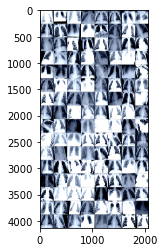

In [14]:
# 导入SummaryWriter
from torch.utils.tensorboard import SummaryWriter
# SummaryWriter() 向事件文件写入事件和概要

# 定义日志路径
log_path = 'logdir/'

# 定义函数：获取tensorboard writer
def tb_writer():
    timestr = time.strftime("%Y%m%d_%H%M%S") # 时间格式
    writer = SummaryWriter(log_path+timestr) # 写入日志
    return writer


writer = tb_writer()

# 第1种方法：显示部分图片集
images, labels = next(iter(dataloaders['train'])) # 获取到一批数据

# 定义图片显示方法
def imshow(img):
    img = img / 2 + 0.5 # 逆正则化
    np_img = img.numpy() # tensor --> numpy
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # 改变通道顺序
    plt.show()
    
grid = utils.make_grid(images) # make_grid的作用是将若干幅图像拼成一幅图像
imshow(grid) # 展示图片

# 在summary中添加图片数据
writer.add_image('X-Ray grid', grid, 0) # add_image(tag, img_tensor, global_step=None, walltime=None, dataformats='CHW')

writer.flush() # 把事件文件写入到磁盘

In [15]:
# 获取一张图片tensor
dataloaders['train'].dataset[4] # 返回：tensor, label

(tensor([[[-0.1828, -0.1486, -0.1314,  ..., -0.6623, -0.5596, -0.3369],
          [-0.1828, -0.1828, -0.1486,  ..., -0.3198, -0.2513, -0.2856],
          [-0.2342, -0.1999, -0.1657,  ..., -0.2856, -0.2856, -0.2856],
          ...,
          [ 0.6392,  0.6392,  0.6392,  ..., -0.6623, -0.6452, -0.6623],
          [ 0.6906,  0.6563,  0.6392,  ..., -0.6452, -0.6452, -0.6623],
          [ 0.6906,  0.6563,  0.6392,  ..., -0.6281, -0.6452, -0.6452]],
 
         [[-0.0574, -0.0224, -0.0049,  ..., -0.5476, -0.4426, -0.2150],
          [-0.0574, -0.0574, -0.0224,  ..., -0.1975, -0.1275, -0.1625],
          [-0.1099, -0.0749, -0.0399,  ..., -0.1625, -0.1625, -0.1625],
          ...,
          [ 0.7829,  0.7829,  0.7829,  ..., -0.5476, -0.5301, -0.5476],
          [ 0.8354,  0.8004,  0.7829,  ..., -0.5301, -0.5301, -0.5476],
          [ 0.8354,  0.8004,  0.7829,  ..., -0.5126, -0.5301, -0.5301]],
 
         [[ 0.1651,  0.1999,  0.2173,  ..., -0.3230, -0.2184,  0.0082],
          [ 0.1651,  0.1651,

Label :  Bacteria


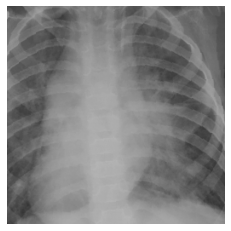

In [16]:
# 第2种方法：显示一张图片
def show_sample(img, label):
    print("Label : ", dataloaders['train'].dataset.classes[label]) # 输出标签
    img = img.numpy().transpose((1, 2, 0)) # 改变shape顺序
    mean = np.array([0.485, 0.456, 0.406]) # 均值
    std = np.array([0.229, 0.224, 0.225]) # 标准差
    img = img * std + mean # 逆向复原
    img = np.clip(img, 0, 1) # np.clip() 将inp中的元素值限制在(0,1)之间，最小值为0，最大值为1。小于min的等于min，大于max等于max
    plt.imshow(img)
    plt.axis('off') # 关闭坐标轴

show_sample(*dataloaders['train'].dataset[4]) # 显示第5张图片

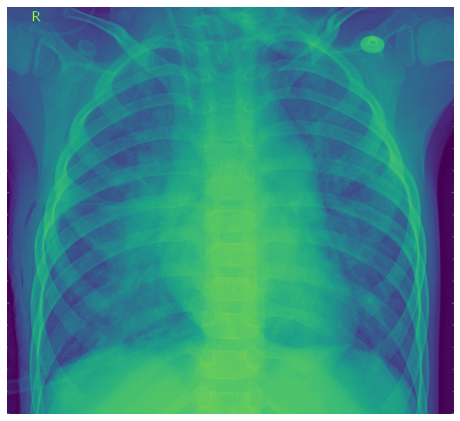

In [17]:
# 第3种方法：显示一张图片
def show_image(img):
    plt.figure(figsize=(8,8)) # 显示大小
    plt.imshow(img) # 显示图片
    plt.axis('off') # 关闭坐标轴
    plt.show()
    
# 读取图片
one_img = Image.open(dataloaders['train'].dataset.root+'Bacteria/bacteria (1001).jpeg')

# 调用函数
show_image(one_img)

In [18]:
# 记录错误分类的图片
def misclassified_images(pred, writer, target, images, output, epoch, count=10):
    misclassified = (pred != target.data) # 判断是否一致
    for index, image_tensor in enumerate(images[misclassified][:count]):
        img_name = 'Epoch:{}-->Predict:{}-->Actual:{}'.format(epoch, LABEL[pred[misclassified].tolist()[index]],
                                                              LABEL[target.data[misclassified].tolist()[index]])
        writer.add_image(img_name, image_tensor, epoch)

In [19]:
# 自定义池化层

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, size=None):
        super(AdaptiveConcatPool2d,self).__init__()
        size = size or (1, 1) # kernel大小
        # 自适应算法能够自动帮助我们计算核的大小和每次移动的步长。
        self.avgPooling = nn.AdaptiveAvgPool2d(size) # 自适应平均池化
        self.maxPooling = nn.AdaptiveMaxPool2d(size) # 最大池化
    def forward(self, x):
        # 拼接avg和max
        return torch.cat([self.maxPooling(x), self.avgPooling(x)], dim=1)

In [20]:
# 迁移学习：获取预训练模型，并替换池化层和全连接层
# def get_model():
#     # 获取欲训练模型 restnet50
#     model = models.resnet50(pretrained=True) 
#     # 冻结模型参数
#     for param in model.parameters():
#         param.requires_grad = False 
#     # 替换最后2层：池化层和全连接层
#     # 池化层
#     model.avgpool = AdaptiveConcatPool2d()
#     # 全连接层
#     model.fc = nn.Sequential(
#         nn.Flatten(), # 拉平
#         nn.BatchNorm1d(4096), # 加速神经网络的收敛过程，提高训练过程中的稳定性
#         nn.Dropout(0.5), # 丢掉部分神经元
#         nn.Linear(4096, 512), # 全连接层
#         nn.ReLU(), # 激活函数
#         nn.BatchNorm1d(512), 
#         nn.Dropout(0.5),
#         nn.Linear(512, 4), # 4个输出
#         nn.LogSoftmax(dim=1) # 损失函数：将input转换成概率分布的形式，输出4个概率
#     )
#     return model
# def get_model():
#     # 使用VGG-16预训练模型
#     model = models.vgg16(pretrained=True)
#     # 冻结模型参数
#     for param in model.parameters():
#         param.requires_grad = False
#     # 替换最后两层
#     model.avgpool = AdaptiveConcatPool2d()
#     model.classifier = nn.Sequential(
#         nn.Dropout(),
#         nn.Linear(2 * 512, 256),
#         nn.ReLU(inplace=True),
#         nn.Dropout(),
#         nn.Linear(256, 4),
#         nn.LogSoftmax(dim=1)
#     )
#     return model
def get_model():
    # 获取欲训练模型 restnet101
    model = models.resnet101(pretrained=True) 
    # 冻结模型参数
    for param in model.parameters():
        param.requires_grad = False 
    # 替换最后2层：池化层和全连接层
    # 池化层
    model.avgpool = AdaptiveConcatPool2d()
    # 全连接层
    model.fc = nn.Sequential(
        nn.Flatten(), # 拉平
        nn.BatchNorm1d(4096), # 加速神经网络的收敛过程，提高训练过程中的稳定性
        nn.Dropout(0.5), # 丢掉部分神经元
        nn.Linear(4096, 512), # 全连接层
        nn.ReLU(), # 激活函数
        nn.BatchNorm1d(512), 
        nn.Dropout(0.5),
        nn.Linear(512, 4), # 4个输出
        nn.LogSoftmax(dim=1) # 损失函数：将input转换成概率分布的形式，输出4个概率
    )
    return model

In [21]:
# 定义训练函数
def train_val(model, device, train_loader, val_loader, optimizer, criterion, epoch, writer):
    model.train()
    total_loss = 0.0
    val_loss = 0.0
    val_acc = 0
    for batch_id, (images, labels) in enumerate(train_loader):
        # 部署到device上
        images, labels = images.to(device), labels.to(device)
        # 梯度置0
        optimizer.zero_grad()
        # 模型输出
        outputs = model(images)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 累计损失
        total_loss += loss.item() * images.size(0)
    # 平均训练损失
    train_loss = total_loss / len(train_loader.dataset)
    #写入到writer中
    writer.add_scalar('Training Loss', train_loss, epoch)
    # 写入到磁盘
    writer.flush()
    
    model.eval() 
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # 前向传播输出
            loss = criterion(outputs, labels) # 损失
            val_loss += loss.item() * images.size(0) # 累计损失
            _, pred = torch.max(outputs, dim=1) # 获取最大概率的索引
            correct = pred.eq(labels.view_as(pred)) # 返回：tensor([ True,False,True,...,False])
            accuracy = torch.mean(correct.type(torch.FloatTensor)) # 准确率
            val_acc += accuracy.item() * images.size(0) # 累计准确率
        # 平均验证损失
        val_loss = val_loss / len(val_loader.dataset)
        # 平均准确率
        val_acc = val_acc / len(val_loader.dataset)
        
    return train_loss, val_loss, val_acc 

In [22]:
# 定义测试函数
def test(model, device, test_loader, criterion, epoch, writer):
    model.eval()
    total_loss = 0.0
    correct = 0.0 # 正确数
    with torch.no_grad():
        for batch_id, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            # 输出
            outputs = model(images)
            # 损失
            loss = criterion(outputs, labels)
            # 累计损失
            total_loss += loss.item()
            # 获取预测概率最大值的索引
            _, predicted = torch.max(outputs, dim=1)
            # 累计正确预测的数
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            # 错误分类的图片
            misclassified_images(predicted, writer, labels, images, outputs, epoch)
        # 平均损失
        avg_loss = total_loss / len(test_loader.dataset)
        # 计算正确率
        accuracy = 100 * correct / len(test_loader.dataset)
        # 将test的结果写入write
        writer.add_scalar("Test Loss", total_loss, epoch)
        writer.add_scalar("Accuracy", accuracy, epoch)
        writer.flush()
        return total_loss, accuracy

In [23]:
# 定义训练流程

# 是否有GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device.type)

# 模型部署到device
model = get_model().to(device)

# 损失函数
criterion = nn.NLLLoss()

# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.001)

# 定义训练流程函数
def train_epochs(model, device, dataloaders, criterion, optimizer, epochs, writer):
    # 输出信息
    print("{0:>15} | {1:>15} | {2:>15} | {3:>15} | {4:>15} | {5:>15}".format('Epoch', 'Train Loss', 'val_loss', 'val_acc', 'Test Loss', 'Test_acc'))
    # 初始最小的损失
    best_loss = np.inf
    # 开始训练、测试
    for epoch in range(epochs):
        # 训练，return: loss
        train_loss, val_loss, val_acc = train_val(model, device, dataloaders['train'], dataloaders['val'], optimizer, criterion, epoch, writer)
        # 测试，return: loss + accuracy
        test_loss, test_acc = test(model, device, dataloaders['test'], criterion, epoch, writer)
        # 判断损失是否最小
        if test_loss < best_loss:
            best_loss = test_loss # 保存最小损失
            # 保存模型
            torch.save(model.state_dict(), 'model.pth')
        # 输出结果
        print("{0:>15} | {1:>15} | {2:>15} | {3:>15} | {4:>15} | {5:>15}".format(epoch, train_loss, val_loss, val_acc, test_loss, test_acc))
        writer.flush()

cpu


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 调用函数
epochs=20
train_epochs(model, device, dataloaders, criterion, optimizer, epochs, writer)
writer.close()

          Epoch |      Train Loss |        val_loss |         val_acc |       Test Loss |        Test_acc
              0 | 1.2150184727668762 | 1.0755194759368896 | 0.5528571438789368 | 23.484921157360077 | 54.892857142857146
              1 | 0.9318042615890503 | 1.0562020295006889 | 0.5614285731315612 | 22.87235152721405 | 55.035714285714285


In [ ]:
def plot_confusion(cm):
    plt.figure()
    plot_confusion_matrix(cm, figsize=(12, 8), cmap=plt.cm.Blues) # 参数设置
    plt.xticks(range(4), ['Bacteria', 'Covid19', 'Normal', 'Viral'], fontsize=14)
    plt.yticks(range(4), ['Bacteria', 'Covid19', 'Normal', 'Viral'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.show()

In [ ]:
# def accuracy(outputs, labels):
#     # 计算正确率
#     _, preds = torch.max(outputs, dim=1)
#     correct = torch.tensor(torch.sum(preds == labels).item() / len(preds))
#     return correct

In [ ]:
# def metrics(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     # precision, recall, F1
#     # 混淆矩阵
#     cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
#     # 绘制混淆矩阵
#     plot_confusion(cm) 
#     # 获取tn, fp, fn, tp
# #     tn, fp, fn, tp = cm.ravel()
#     fp = cm.sum(axis=0) - np.diag(cm)
#     fn = cm.sum(axis=1) - np.diag(cm)
#     tp = np.diag(cm)
#     tn = cm.sum() - (fp + fn + tp)
#     print(fp)
#     print(fn)
#     # 精准率
#     precision = tp / (tp + fp)
#     # 召回率
#     recall = tp / (tp + fn)
#     # f1 score
#     f1 = 2 * ((precision * recall) / (precision + recall))
# #     print(precision)
# #     print(recall)
# #     print(f1)
#     return precision, recall, f1

In [ ]:
# 计算testloader
# precisions = []
# recalls = []
# f1s = []
# accuracies = []

all_preds = []
all_labels = []

with torch.no_grad():
    model.eval()
    for datas, labels in dataloaders['test']:
        datas, labels = datas.to(device), labels.to(device)
        # 预测输出 前向传播
        outputs = model(datas)
        _, preds = torch.max(outputs, dim=1)
#     将预测结果和真实标签添加到列表中
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        # precision, recall, F1
        # 混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    # 绘制混淆矩阵
    plot_confusion(cm) 
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    # 精准率
    precision = tp / (tp + fp)
    # 召回率
    recall = tp / (tp + fn)
    # f1 score
    f1 = 2 * ((precision * recall) / (precision + recall))
    num_correct = 0
    num_total = len(all_labels)
    for pred, label in zip(all_preds, all_labels):
        if pred == label:
            num_correct += 1
            acc = num_correct / num_total
#     acc = torch.tensor(torch.sum(all_preds == all_labels.data).item() / len(all_preds))
    print(precision)
    print(recall)
    print(f1)
    print(acc)
#         # 计算metrics
#         precision, recall, f1 = metrics(outputs, labels)
#         acc = accuracy(outputs, labels)
#         print(acc)
#         # 保存结果
#         recalls.append(recall)
#         precisions.append(precision)
#         f1s.append(f1)
#         accuracies.append(acc.item())
#         print(precisions)
#         print(recalls)
#         print(f1)
#         print(accuracies)

In [ ]:
# ['{:.2f}%'.format(pre*100) for pre in precisions]# 精准率 precision

In [ ]:
# ['{:.2f}%'.format(r*100) for r in recalls]# 召回率 recall

In [ ]:
# ['{:.2f}%'.format(f*100) for f in f1s]# f1

In [ ]:
# ['{:.2f}%'.format(a*100) for a in accuracies]# 准确率 accuracy